In [1]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
results_fldr = "/run/media/dylan/My Passport/maskrcnn_isic_models"

In [3]:
runs = [f for f in os.listdir(results_fldr) if "e2e_mask_rcnn" in f]

In [4]:
import math
import cv2
import numpy as np

In [5]:
import multiprocessing as mp


def proc(res_by_id, filename):
    base_filename = os.path.splitext(filename)[0]
    id_ = int(base_filename[5:])
    if id_ not in res_by_id:
        return 1
    mask_filename = base_filename + "_segmentation.png"
    mask_path = os.path.join("/data/sd0/here/isic_fmt/masks",
                             mask_filename)
    _, mask = cv2.threshold(
        cv2.imread(mask_path, 0),
        256 // 2, 255, cv2.THRESH_BINARY)
    bboxes = res_by_id[id_]
    best = max(bboxes, key=lambda x: x["score"])
    bottom, left, width, height = best["bbox"]

    bottom = math.floor(bottom)
    left = math.floor(left)
    width = math.ceil(width) + 1
    height = math.ceil(height) + 1

    c0 = bottom
    cf = bottom + width
    r0 = left
    rf = left + height

    mask_size = mask.sum()
    mask[r0:rf, c0:cf] = 0
    return mask.sum() / mask_size

data = {}

results_fldr = "/run/media/dylan/My Passport/maskrcnn_isic_models"
runs = (f for f in os.listdir(results_fldr) if "e2e_mask_rcnn" in f)

with mp.Pool() as p:
    for run in runs:
        try:
            ckpts = os.listdir(
                    os.path.join(results_fldr, run, "grid_search_step", "test"))
        except Exception as e:
            print(e)
            continue
        data[run] = {}
        ckpts = sorted(ckpts, key=lambda x: int("".join([c for c in x if c.isnumeric()])))
        for ckpt in ckpts:
            bb_json = os.path.join(
                results_fldr, run, "grid_search_step", "test", ckpt,
                "bbox_isic_2018_val_results.json")
            try:
                with open(bb_json, "r") as f:
                    bb_results = json.load(f)
            except Exception as e:
                print(e)
                continue
            res_by_id = {}
            for res in bb_results:
                isic_id = (res["image_id"] - 1) / 4
                if isic_id != int(isic_id):
                    assert False
                isic_id = int(isic_id)
                try:
                    res_by_id[isic_id].append(res)
                except KeyError:
                    res_by_id[isic_id] = [res]

            all_ = p.starmap(
                proc,
                ((res_by_id, f) for f in os.listdir("/data/sd0/here/isic_fmt/images/val2018")))

            data[run][int("".join([c for c in ckpt if c.isnumeric()]))] = all_

            print(run, "mean:", np.mean(all_), "std:", np.std(all_))

e2e_mask_rcnn_R-101-FPN_1x mean: 0.039739683180185226 std: 0.11032137892985841
e2e_mask_rcnn_R-101-FPN_1x mean: 0.025067030632701024 std: 0.07279094393916713
e2e_mask_rcnn_R-101-FPN_1x mean: 0.01795138219428394 std: 0.06994871322773631
e2e_mask_rcnn_R-101-FPN_1x mean: 0.027377597376174803 std: 0.08065568613854752
e2e_mask_rcnn_R-101-FPN_1x mean: 0.041678064451941124 std: 0.09397415884803956
e2e_mask_rcnn_R-101-FPN_1x mean: 0.031149773600167963 std: 0.09210149883538288
e2e_mask_rcnn_R-101-FPN_1x mean: 0.034744068926992944 std: 0.11046637520904323
e2e_mask_rcnn_R-101-FPN_1x mean: 0.04669346515748955 std: 0.13521108859664496
e2e_mask_rcnn_R-101-FPN_2x mean: 0.030327832905735392 std: 0.07516574942135858
e2e_mask_rcnn_R-101-FPN_2x mean: 0.0175611079384501 std: 0.08061954732388513
e2e_mask_rcnn_R-101-FPN_2x mean: 0.03195424229954095 std: 0.09815382033278784
e2e_mask_rcnn_R-101-FPN_2x mean: 0.02722934294152429 std: 0.0948641860511457
e2e_mask_rcnn_R-101-FPN_2x mean: 0.022558841396138434 std: 

In [6]:
print(data)

{'e2e_mask_rcnn_R-101-FPN_1x': {4999: [0.1475983052729312, 0.00772277289040413, 0.011235308948879344, 0.006740265408052759, 0.016454998307297963, 0.007454689008572604, 0.0036507483934513827, 0.0, 0.004456857384497374, 0.0, 0.007446644046834444, 0.05011965005740883, 0.09362605315935364, 0.016456438380088246, 0.04584936299137941, 0.0013941251864455055, 0.042751316454943025, 0.02205010669406465, 0.02468190622018317, 2.5808183258747684e-06, 0.0009701174430056002, 0.000898069929827451, 0.002803162728351342, 0.04843295399200859, 0.05597464327195282, 0.020377991508082335, 0.002395970199910613, 0.007985065098640054, 0.07530620317426139, 0.046382992553266215, 0.0, 0.0, 0.038918057560229, 0.0, 0.025781671505279654, 1.0, 0.09735980895099947, 0.005243080645974423, 0.08258492916867721, 0.004073926868044515, 0.0, 0.044523046609344655, 0.03667012116858266, 0.14181788873200335, 0.05290571906121133, 0.0032695836694039506, 0.00097747803399734, 0.0012801434315719102, 0.0, 0.0009696229096656793, 0.0303484

In [7]:
import pandas as pd
import seaborn as sns
sns.set()

In [8]:
df = pd.DataFrame(data)

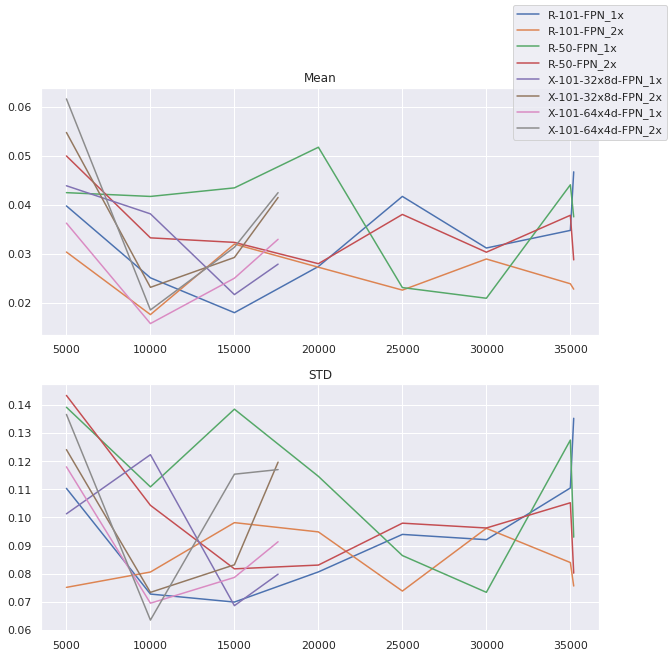

In [9]:
fig, (ax_mean, ax_std) = plt.subplots(2, 1, figsize=(10, 10))
leg = []
for arch in df.keys():
    col = df[arch]
    means = col.apply(np.mean)
    stds = col.apply(np.std)
    means = means[~means.isna()]
    stds = stds[~stds.isna()]
    ax_mean.plot(means.index, means)
    ax_std.plot(stds.index, stds)
    leg.append(arch.lstrip("e2e_mask_rcnn_"))
ax_mean.set_title("Mean")
ax_std.set_title("STD")
fig.legend(leg)

In [10]:
flatter_data = []
for k, group in data.items():
    for step, errs in group.items():
        for err in errs:
            flatter_data.append({
                "arch": k.lstrip("e2e_mask_rcnn_"),
                "step": step,
                "err": err
            })

In [11]:
df2 = pd.DataFrame(flatter_data)
df2["err"] *= 100

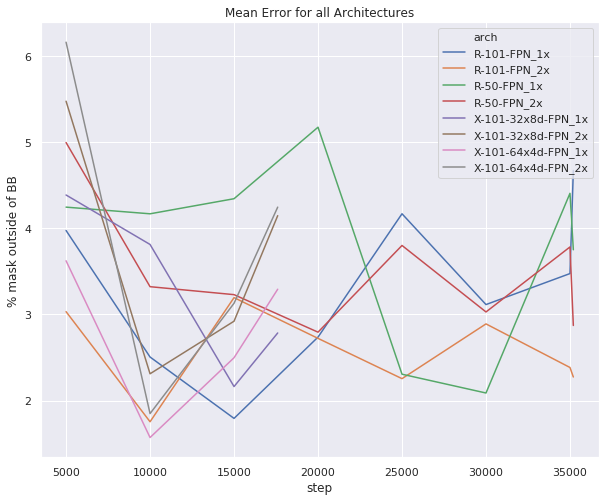

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(x="step", y="err", hue="arch", data=df2, ax=ax, ci=None)
ax.set_title("Mean Error for all Architectures")
ax.set_ylabel("% mask outside of BB")
ax.figure.savefig("gridsearch.png", dpi=300)

/home/dylan/miniconda/envs/mask-rcnn-pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


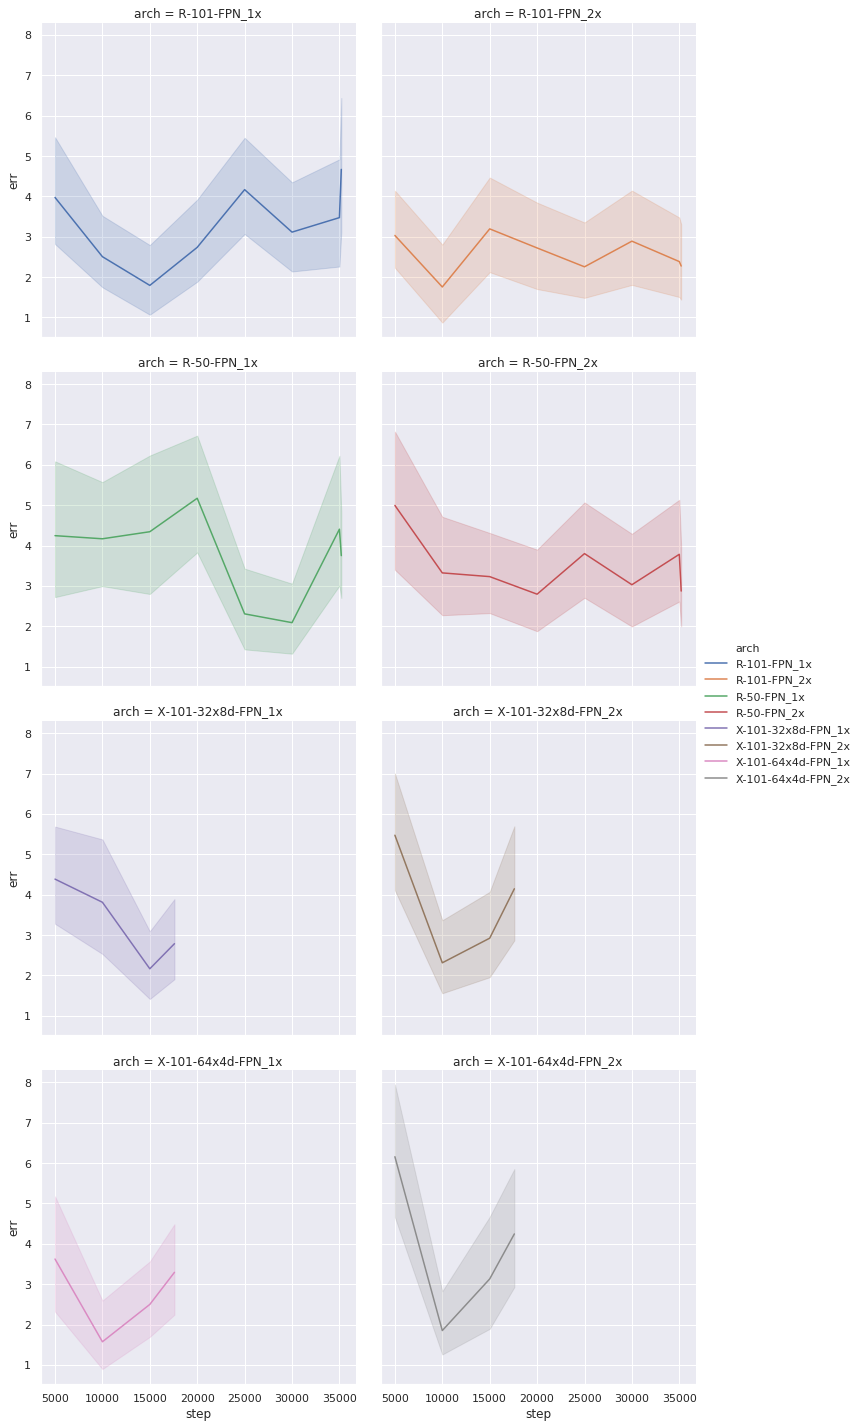

In [56]:
ax = sns.relplot(x="step",
            y="err", col="arch", hue="arch", data=df2,
            ci=95, col_wrap=2, kind='line', estimator=np.mean)

ax.savefig("all_archs_areas.png", dpi=300)

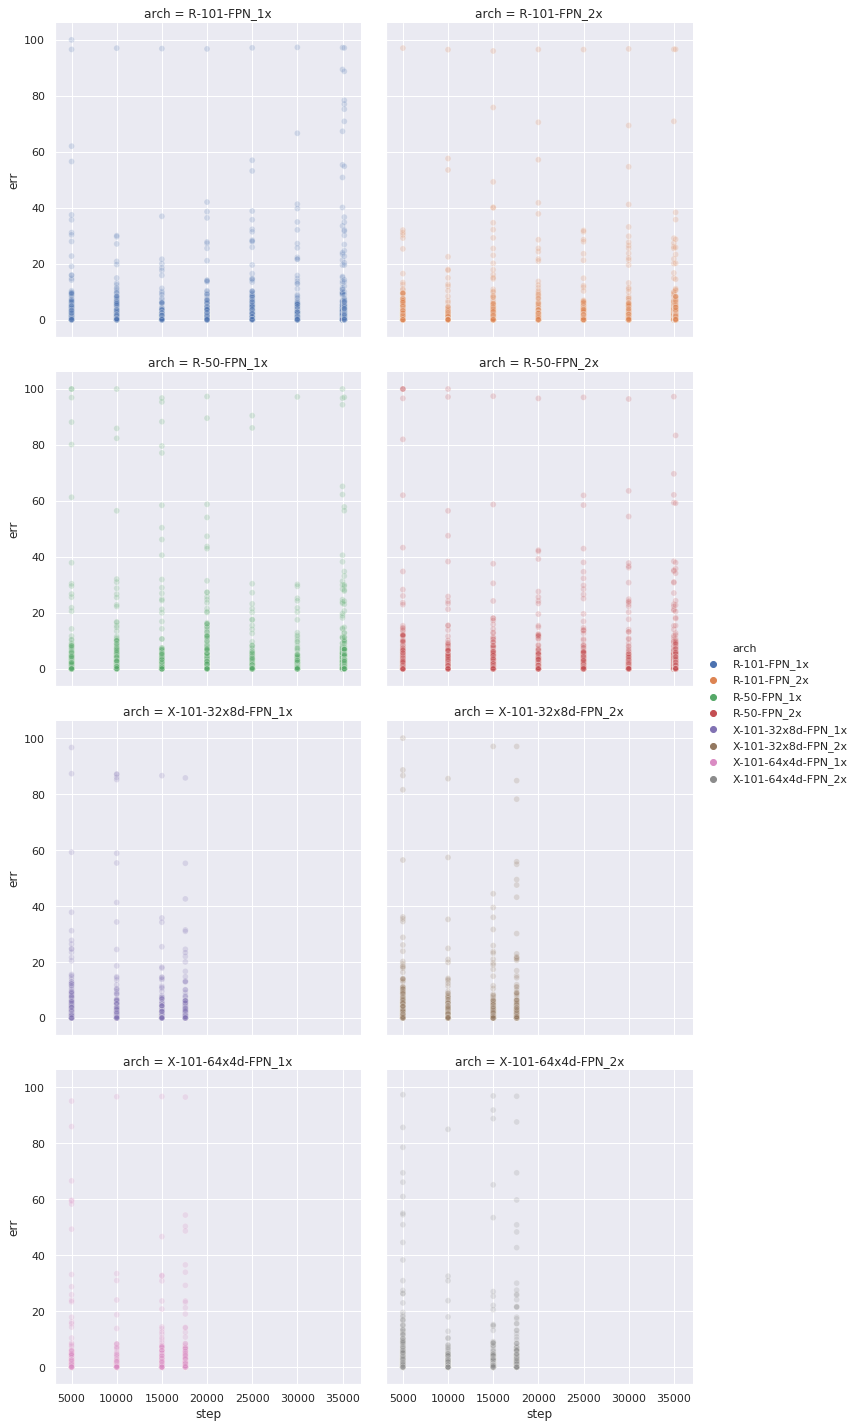

In [63]:
g = sns.relplot(x="step",
            y="err", col="arch", hue="arch", data=df2,
            ci=95, col_wrap=2, estimator=np.mean, alpha=0.2)

# ax.savefig("all_archs_areas.png", dpi=300)

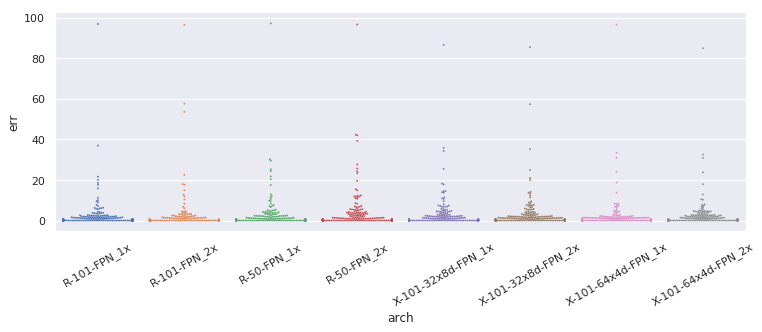

In [248]:
g = sns.catplot(kind='swarm',
    x="arch", y="err", hue="arch", data=merged, height=4, aspect=2.7, s=1.8, alpha=1)
g.set_xticklabels(rotation=30)
g.savefig("best_swarms.png", dpi=300)

/home/dylan/miniconda/envs/mask-rcnn-pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


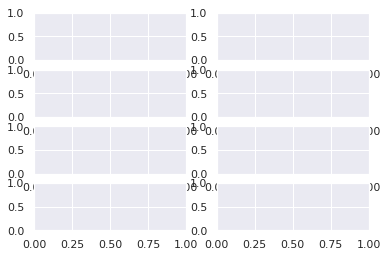

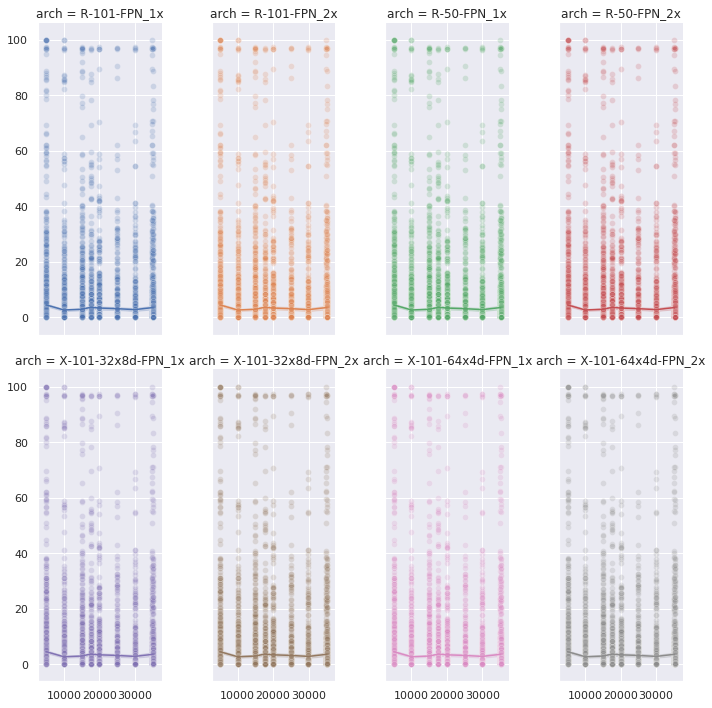

In [145]:

order = list(df2["arch"].unique())

fig, axes = plt.subplots(4, 2)

# g = sns.relplot(data=df2, x="step",
#         y="err", kind='line',
#         ci=95, estimator=np.mean, alpha=0.2, col_order=order,
#        col="arch", hue="arch", aspect=4, height=2, col_wrap=2);

# for arch, ax in zip(order, g.axes):
#     dat = df2[df2['arch'] == arch]
#     sns.pointplot(data=dat, x="step", y="err", alpha=0.2, axis=ax)
# g.map(sns.catplot, data=df2, x="step",
#             y="err",
#             alpha=0.2, col_order=order)

g = sns.FacetGrid(data=df2, col="arch", hue="arch", aspect=0.5, height=5, col_wrap=4, col_order=order)
g.map(sns.lineplot, data=df2, x="step", y="err", ci=95, estimator=np.mean)
g.map(sns.scatterplot, data=df2, x="step", y="err", alpha=0.2)

# ax.savefig("all_archs_areas.png", dpi=300)

/home/dylan/miniconda/envs/mask-rcnn-pytorch/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/home/dylan/miniconda/envs/mask-rcnn-pytorch/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/home/dylan/miniconda/envs/mask-rcnn-pytorch/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/home/dylan/miniconda/envs/mask-rcnn-pytorch/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodat

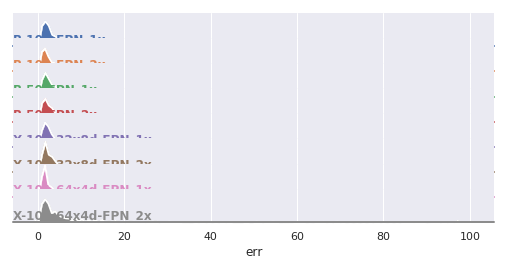

In [73]:
# Initialize the FacetGrid object
g = sns.FacetGrid(data=df2, row="arch", hue="arch", aspect=15, height=.5)

# Draw the densities in a few steps
g.map(sns.kdeplot, "err", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "err", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "err")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

R-101-FPN_1x 14999 1.7951382194283942
R-101-FPN_2x 9999 1.7561107938450098
R-50-FPN_1x 29999 2.0894357343883767
R-50-FPN_2x 19999 2.7948772982616816
X-101-32x8d-FPN_1x 14999 2.164152216342698
X-101-32x8d-FPN_2x 9999 2.312374893544998
X-101-64x4d-FPN_1x 9999 1.5730998468585886
X-101-64x4d-FPN_2x 9999 1.8507101939970125


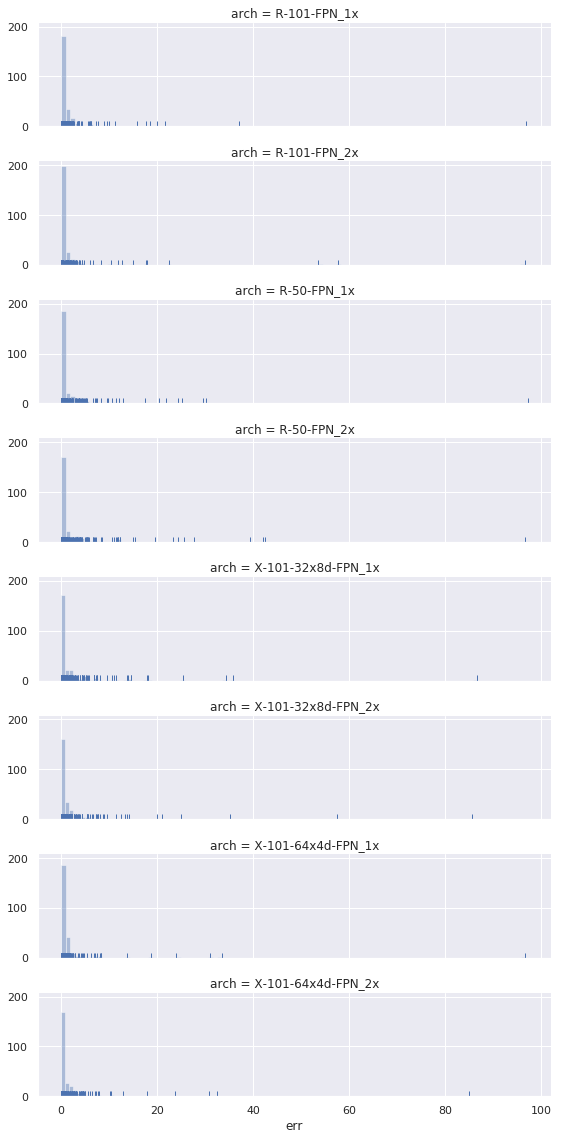

In [50]:
best_data = []
for d in df2.groupby("arch"):
    arch = d[0]
    data = d[1]
    lowest_err = 100
    lowest_step = 0
    lowest_dat = None
    for x in data.groupby("step"):
        step = x[0]
        dat = x[1]
        if dat["err"].mean() < lowest_err:
            lowest_err = dat["err"].mean()
            lowest_step = step
            lowest_dat = dat
    best_data.append(lowest_dat)
    print(arch, lowest_step, lowest_err)
#     sns.distplot(lowest_dat['err'])

merged = pd.concat(best_data)
    
g = sns.FacetGrid(merged, row="arch",
                  height=2, aspect=4,)
g.map(sns.distplot, "err", bins=101, kde=False, rug=True)

In [ ]:
g = sns.FacetGrid(merged, row="arch",
                  height=2, aspect=4,)
g.map(sns.distplot, "err", bins=101, kde=False, rug=True)

In [14]:
df_mean = df.applymap(np.mean)

In [15]:
table = df_mean.round(4).astype(str)

In [16]:
for k, v in table.items():
    if k.startswith("e2e_mask_rcnn_"):
        table[k.lstrip("e2e_mask_rcnn_")] = v
        del table[k]

In [17]:
table = table.replace("nan", "")

In [18]:
print(table.transpose().to_latex())

\begin{tabular}{llllllllll}
\toprule
{} &   4999  &   9999  &   14999 &   17599 &   19999 &   24999 &   29999 &   34999 &   35199 \\
\midrule
R-101-FPN\_1x       &  0.0397 &  0.0251 &   0.018 &         &  0.0274 &  0.0417 &  0.0311 &  0.0347 &  0.0467 \\
R-101-FPN\_2x       &  0.0303 &  0.0176 &   0.032 &         &  0.0272 &  0.0226 &  0.0289 &  0.0239 &  0.0228 \\
R-50-FPN\_1x        &  0.0424 &  0.0417 &  0.0434 &         &  0.0517 &  0.0231 &  0.0209 &   0.044 &  0.0375 \\
R-50-FPN\_2x        &  0.0499 &  0.0332 &  0.0323 &         &  0.0279 &   0.038 &  0.0303 &  0.0378 &  0.0287 \\
X-101-32x8d-FPN\_1x &  0.0439 &  0.0381 &  0.0216 &  0.0279 &         &         &         &         &         \\
X-101-32x8d-FPN\_2x &  0.0547 &  0.0231 &  0.0292 &  0.0415 &         &         &         &         &         \\
X-101-64x4d-FPN\_1x &  0.0362 &  0.0157 &   0.025 &  0.0329 &         &         &         &         &         \\
X-101-64x4d-FPN\_2x &  0.0616 &  0.0185 &  0.0313 &  0.0424 &      